## A11535519 - Justin Laughlin
### MAE 290A: Homework 1 (10/19/17)
### Problem 2

In [2]:
# Import necessary packages & configure settings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Governing equation:

One dimensional Poisson equation with Dirichlet BCs $u(0)=u(1)=0$

$$\frac{\partial^2 u}{\partial x^2} = f(x) = \cos{(2\pi x)} - 1$$

### Solving for $u(x)$ analytically

Since $u=u(x)$ we can easily solve this equation analytically by integrating twice...

$$\frac{\partial u}{\partial x} = \frac{1}{2\pi}\sin{(2\pi x)} - x + A$$
$$u(x) = \frac{-1}{(2\pi)^2}\cos{(2\pi x)} - \frac{x^2}{2} + Ax + B$$

Applying the BCs gives:

$$u(0) = 0 = \frac{-1}{(2\pi)^2} + B \rightarrow \boxed{B=\frac{1}{(2\pi)^2}}$$
$$u(1) = 0 = \frac{-1}{(2\pi)^2}\cos{(2\pi)} - \frac{1}{2} + A + \frac{1}{(2\pi)^2} \rightarrow \boxed{A=\frac12}$$

And plugging $A$ and $B$ into our solution gives:
$$\boxed{u(x) = \frac{1}{(2\pi)^2} \left(1 - \cos{2\pi x} \right) + \frac{x}{2} \left(1 - x\right)}$$

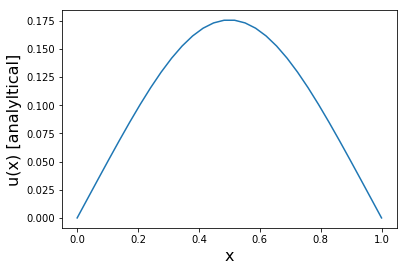

In [3]:
# Let's plot u(x) to see what it looks like!
x  = np.linspace(0,1,num=30)
ua = (1 - np.cos(2*np.pi*x))/(2*np.pi)**2 + x/2 * (1-x)

plt.plot(x,ua)
plt.ylabel('u(x) [analyltical]', fontsize=16)
plt.xlabel('x', fontsize=16)

### Discretizing $u(x)$

Discretize the domain $x \in [0,1]$ into $N$ grid points:
$$x_i = (i-1) \cdot h$$
$$h = \frac{1}{N-1}$$

Use the second order central difference equation

$$\frac{\partial^2 u}{\partial x^2} = \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$$

Our governing equation can now be re-written as

$$\boxed{u_{i+1} - 2u_i + u_{i-1} = h^2\left[\cos{(2\pi x_i)} - 1\right]}$$

### Re-writing discretized equation in matrix form ($\mathbf{A} \cdot \mathbf{u} = \mathbf{f}$)

Constructing the matrix for $N=7$... Since the values of $u(0)=u_0$ and $u(1)=u_6$ are equal to $0$ (known), their rows have been adjusted to match this condition

$$\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0\\
1 & -2 & 1 & 0 & 0 & 0 & 0\\
0 & 1 & -2 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & -2 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & -2 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & -2 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
u_0 \\
u_1 \\
u_2 \\
u_3 \\
u_4 \\
u_5 \\
u_6 \\
\end{pmatrix} =
h^2 \begin{pmatrix}
\cos{(2\pi x_0)} - 1 \\
\cos{(2\pi x_1)} - 1 \\
\cos{(2\pi x_2)} - 1 \\
\cos{(2\pi x_3)} - 1 \\
\cos{(2\pi x_4)} - 1 \\
\cos{(2\pi x_5)} - 1 \\
\cos{(2\pi x_6)} - 1 
\end{pmatrix}$$

Since this is a tri-diagonal matrix we can solve the matrix inversion problem in $\mathcal{O}(N)$ instead of the typical cost of $\sim \mathcal{O}(N^3)$ (yay!). To do so we rewrite the equation as
$$a_i u_{i-1} + b_i u_i + c_i u_{i+1} = f_i$$

where $a_i$, $b_i$, and $c_i$ are the values of the $i$th row for the lower, main, and upper diagonals, respectively.

Note: $a[0]$ and $c[N-1]$ will be undefined (or set to $0$) as they are not a part of the matrix. Also $f[0]=f[N-1]=0$ (can check by evaluating) which satisfies our boundary conditions.

In [4]:
# Initialize all variables necessary for the tri-diagonal matrix formulation
N = 30 # number of nodes
x = np.linspace(0,1,N) # discretized domain
h = 1/(N-1) # spacing between nodes
a = np.concatenate((np.zeros(1), np.ones((N-2,), dtype=np.double), np.zeros(1))) # lower diagonal
b = np.concatenate((np.ones(1), -2 * np.ones((N-2,), dtype=np.double), np.ones(1))) # main diagonal
c = np.concatenate((np.zeros(1), np.ones((N-2,), dtype=np.double), np.zeros(1))) # upper diagonal
f = h**2 * (np.cos(2*np.pi*x) - 1) # RHS vector

In [5]:
# Function that solves the tridiagonal matrix
def tridiag(a,b,c,f):

    # Initialize
    N = len(f)
    u = np.ndarray((N,), dtype=np.double)
    gam = np.ndarray((N,), dtype=np.double)
    if (b[0] == 0.0):
        print("ERROR 1 in tridiag()")
        return
    else:
        bet = b[0]

    # Decomposition & forward substitution
    for j in np.arange(1,N):
        gam[j] = c[j-1] / bet
        bet    = b[j] - a[j]*gam[j]
        if (bet==0.0):
            print("ERROR 2 in tridiag()")
        else:
            u[j] = (f[j]-a[j]*u[j-1])/bet
    # Backsubstitution
    for j in np.arange(N-2,-1,-1):
        u[j] -= gam[j+1]*u[j+1]
        
    return u

In [6]:
# Solve the system
u = tridiag(a,b,c,f)

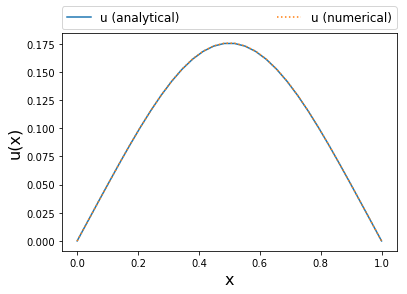

In [15]:
# Plot results. Compare with analytical
plt.plot(x,ua, label="u (analytical)")
plt.plot(x,u, linestyle=':', label="u (numerical)")
plt.ylabel('u(x)', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=12)

Results seem to match the analytical solution quite welll! Lets find the maximum error (in terms of absolute difference) between the two solutions...

In [7]:
print("Maximum error between analytical and numerical solutions is: ",np.max(np.abs(u-ua)))

Maximum error between analytical and numerical solutions is:  0.000198060558323
